In [1]:
from ultralytics import YOLO
import cv2
import easyocr
from gtts import gTTS
from pydub import AudioSegment
import pygame
import time
import os
import uuid
import matplotlib.pyplot as plt

pygame 2.6.1 (SDL 2.28.4, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
model = YOLO("best.pt")


0: 640x640 4 0s, 1 3, 169.1ms
Speed: 6.3ms preprocess, 169.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected text: Cyclists use cycle lane only
Detected text: Except for cycles
Detected text: Rising bollard


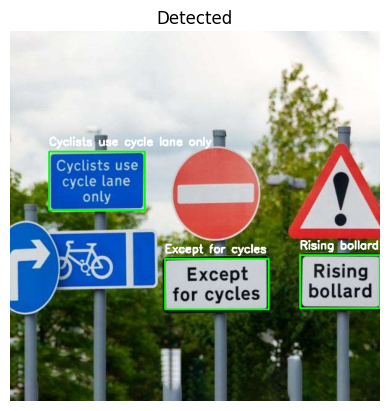

In [28]:

img_path = 'WhatsApp Image 2025-07-13 at 21.25.36_ce24d11b.jpg'
img = cv2.imread(img_path)
results = model(img)[0]

reader = easyocr.Reader(['en'])
pygame.init()
pygame.mixer.init()

for box in results.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cropped = img[y1:y2, x1:x2]
    text_blocks = reader.readtext(cropped)
    full_text = ' '.join([text for (_, text, _) in text_blocks]).strip()
    if not full_text:
        continue
    print(f"Detected text: {full_text}")

    temp_id = str(uuid.uuid4())
    mp3_file = f"{temp_id}.mp3"
    wav_file = f"{temp_id}.wav"

    try:
        gTTS(text=full_text, lang='en').save(mp3_file)
        time.sleep(0.5)
        AudioSegment.from_mp3(mp3_file).export(wav_file, format="wav")
        pygame.mixer.music.load(wav_file)
        pygame.mixer.music.play()
        while pygame.mixer.music.get_busy():
            time.sleep(0.1)

    except Exception as e:
        print("Audio error:", e)
    finally:
        try:
            pygame.mixer.music.unload()
        except:
            pass
        time.sleep(1.0)
        for f in [mp3_file, wav_file]:
            for _ in range(3):
                try:
                    if os.path.exists(f):
                        os.remove(f)
                        break  
                except Exception as e:
                    print(f"Retrying delete for {f}...")
                    time.sleep(0.5)
                    
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, full_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.6, (255, 255, 255), 2)
    
pygame.mixer.quit()

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Detected")
plt.show()

In [30]:
from ultralytics import YOLO
import cv2
import easyocr
from gtts import gTTS
from pydub import AudioSegment
import pygame
import time
import os
import uuid

# Load YOLO model and OCR
model = YOLO("best.pt")
reader = easyocr.Reader(['en'])

# Custom class names
custom_class_map = {
    0: "stop sign",
    1: "no entry",
    2: "turn left",
    3: "warning",
    4: "construction",
    5: "speed limit"
}
ignored_classes = [3]

# Audio setup
pygame.init()
pygame.mixer.init()

# Camera setup
cap = cv2.VideoCapture(1)
spoken_recently = ""
last_spoken_time = 0
cooldown = 2
stable_delay = 0.6
frame_skip = 5
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % frame_skip != 0:
        cv2.imshow("Signboard Reader", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        continue

    now = time.time()
    if now - last_spoken_time > cooldown:
        time.sleep(stable_delay)
        ret, stable_frame = cap.read()
        if not ret:
            continue

        results = model(stable_frame, conf=0.4)[0]
        for box in results.boxes:
            class_id = int(box.cls[0])
            conf = float(box.conf[0])
            print(f"Detected class {class_id} ({custom_class_map.get(class_id, 'unknown')}), Confidence: {conf:.2f}")

            if class_id in ignored_classes or class_id not in custom_class_map:
                continue

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cropped = stable_frame[y1:y2, x1:x2]

            text_blocks = reader.readtext(cropped)
            valid_texts = [text for (_, text, conf) in text_blocks if conf > 0.5]
            full_text = ' '.join(valid_texts).strip()

            to_speak = full_text if full_text else custom_class_map[class_id]
            if not to_speak or to_speak == spoken_recently:
                continue

            print(f"Speaking: {to_speak}")
            spoken_recently = to_speak
            last_spoken_time = time.time()

            temp_id = str(uuid.uuid4())
            mp3_path = f"{temp_id}.mp3"
            wav_path = f"{temp_id}.wav"

            try:
                gTTS(text=to_speak.replace("_", " "), lang='en').save(mp3_path)
                AudioSegment.from_mp3(mp3_path).export(wav_path, format="wav")
                pygame.mixer.music.load(wav_path)
                pygame.mixer.music.play()
                while pygame.mixer.music.get_busy():
                    time.sleep(0.1)
            except Exception as e:
                print("Audio error:", e)
            finally:
                try:
                    pygame.mixer.music.unload()
                    time.sleep(0.2)
                    if os.path.exists(mp3_path): os.remove(mp3_path)
                    if os.path.exists(wav_path): os.remove(wav_path)
                except:
                    pass

            cv2.rectangle(stable_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(stable_frame, to_speak, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        cv2.imshow("Signboard Reader", stable_frame)
    else:
        cv2.imshow("Signboard Reader", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
pygame.mixer.quit()

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.



0: 384x640 (no detections), 124.1ms
Speed: 2.1ms preprocess, 124.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 115.2ms
Speed: 1.7ms preprocess, 115.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 119.5ms
Speed: 1.7ms preprocess, 119.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 122.0ms
Speed: 1.8ms preprocess, 122.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 111.8ms
Speed: 2.2ms preprocess, 111.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 124.4ms
Speed: 1.7ms preprocess, 124.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 0, 106.5ms
Speed: 2.4ms preprocess, 106.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Detected class 0 (stop sign), Confidence: 0.54
Speaking: ELIF SHAFA

In [5]:
import cv2
import numpy as np

print("NumPy version:", np.__version__)
print("OpenCV version:", cv2.__version__)

# Replace with a real image path
img = cv2.imread("61Pr+Eot-eL.jpg")

if img is None:
    print("Image not found!")
else:
    cv2.imshow("Test Window", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

NumPy version: 1.23.5
OpenCV version: 4.6.0
